In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rhessys import utilities as rut
import seaborn as sns
import statsmodels.formula.api as sm
%matplotlib inline

In [2]:
niwot = pd.read_pickle('./data/niwot_new.pcl')
crn = pd.read_pickle('../greenness_timing/data/boulder_co.pcl')
AFX = pd.read_pickle('../greenness_timing/data/AFX2_new.pcl')
nw = pd.read_pickle('./data/niwot_stats.pcl')

In [3]:
niwot['snowfall'] = niwot.snowmelt.copy() # create an accumulation variable

In [4]:
niwot.loc[niwot.snowfall>0,'snowfall'] = 0. # zero melt events

In [5]:
niwot['snowfall'] = niwot.snowfall.abs()

In [6]:
niwot['accum_sf'] = np.NaN

for wy in np.unique(niwot.wateryear):
    niwot.loc[niwot.wateryear == wy,'accum_sf'] = niwot.loc[niwot.wateryear == wy,'snowfall'].cumsum()

In [7]:
crn['wateryear'] = crn.index.map(rut.wateryear)
niwot['wateryear'] = niwot.index.map(rut.wateryear)

In [8]:
wyears = np.unique(crn.wateryear)

In [9]:
wyears = wyears[1:-1]

In [10]:
wyears

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [11]:
# crop everything to the same time period
crn = crn.loc[(crn.wateryear>=2004) & (crn.wateryear<=2014)]
niwot = niwot.loc[(niwot.wateryear>=2004) & (niwot.wateryear<=2014)]
nw = nw.loc[(nw.index>=2004) & (nw.index<=2014)]

In [12]:
niwot.columns

Index([u'Tave', u'Tmax', u'Tmin', u'AccumP', u'P', u'Psnowadj', u'SD', u'SWE',
       u'snowmelt', u'wateryear', u'dowy', u'snowfall', u'accum_sf'],
      dtype='object')

In [13]:
strt[0]

NameError: name 'strt' is not defined

In [14]:
# compute accumulated Snow Season P and SWE

SWE = []
P = []

for wy in wyears:
    strt = nw.loc[nw.index==wy,'accumSeasDate'].as_matrix()[0]
    nd = nw.loc[nw.index==wy,'DateNS'].as_matrix()[0]
    
    SWE.append(niwot.loc[strt:nd,'snowfall'].sum())
    P.append(crn.loc[strt:nd,'P'].sum())

In [15]:
SWE

[495.0, 559.0, 418.0, 592.0, 409.0, 452.0, 453.0, 587.0, 337.0, 482.0, 561.0]

<Container object of 11 artists>

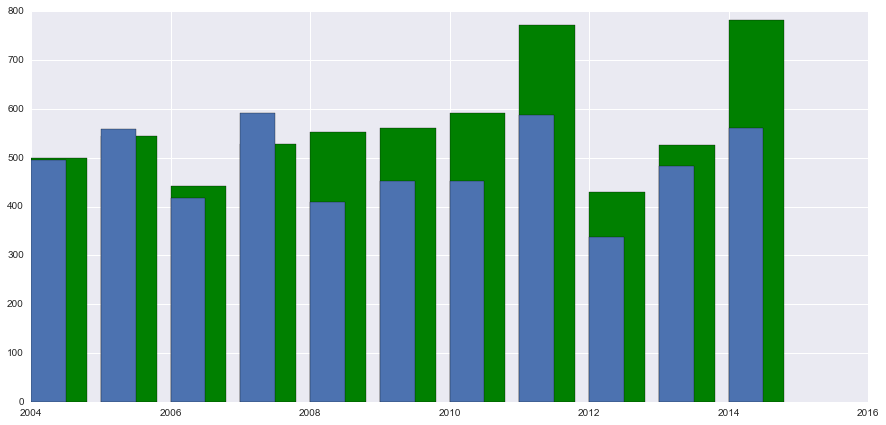

In [16]:
plt.figure(figsize=(15,7))
plt.bar(wyears,P, facecolor='g')
plt.bar(wyears,SWE,width=0.5)


In [17]:
coef = np.array(SWE)/np.array(P) # compute a coeficient to correct P to SWE during the snow season

## Insert Corrected Values of Snow Season P into the CRN Data

In [18]:
crn_corr = crn.copy() # copy the crn data

In [19]:
# loop through each water year and correct the data
for wy,corr in zip(wyears,coef):
    strt = nw.loc[nw.index==wy,'accumSeasDate'].as_matrix()[0]
    nd = nw.loc[nw.index==wy,'DateNS'].as_matrix()[0]
    
    crn_corr.loc[strt:nd,'P'] *= corr # correct the P data during the snow season 

In [20]:
# recalculate WY P for the corrected data
Porg = []
Pcorr = []

for wy in wyears:
    Porg.append(crn.loc[crn.wateryear==wy,'P'].sum())
    Pcorr.append(crn_corr.loc[crn_corr.wateryear==wy,'P'].sum())
    
Porg = np.array(Porg)
Pcorr = np.array(Pcorr)

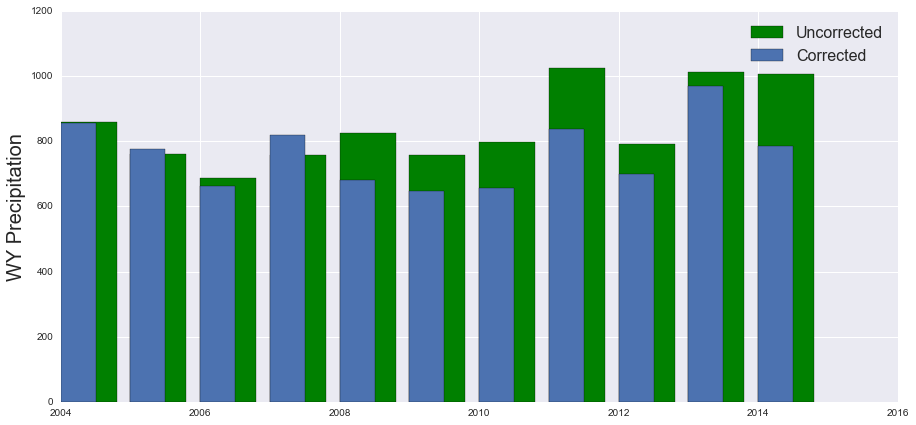

In [21]:
plt.figure(figsize=(15,7))
plt.bar(wyears,Porg, facecolor='g')
plt.bar(wyears,Pcorr,width=0.5)
plt.legend(['Uncorrected','Corrected'],loc='best', fontsize=16)
plt.ylabel('WY Precipitation', fontsize=20)

## Output the data to a new climate basestation

In [22]:
# prep the data for output
crn_corr.loc[np.isnan(crn_corr.P),'P'] = 0. # zero missing precip.
crn_corr.interpolate(inplace=True,method='linear') # interpolate everything else

In [23]:
crn_corr.to_pickle('./data/crn_corr.pcl')

In [141]:
n = len(crn_corr)
P = np.reshape(crn_corr.P.as_matrix(),[n,1]) * 0.001 # convert mm to m
Tmin = np.reshape(crn_corr.Tmin.as_matrix(),[n,1])
Tmax = np.reshape(crn_corr.Tmax.as_matrix(),[n,1])
Tavg = np.reshape(crn_corr.Tave_mod.as_matrix(),[n,1])

In [142]:
header = '2003 10 1'

np.savetxt('/RHESSys/ComoCreek_new/clim/boulder_crn_corr.rain',P,comments='',header=header,fmt='%10.8f')
np.savetxt('/RHESSys/ComoCreek_new/clim/boulder_crn_corr.tmin',Tmin,comments='',header=header,fmt='%10.8f')
np.savetxt('/RHESSys/ComoCreek_new/clim/boulder_crn_corr.tmax',Tmax,comments='',header=header,fmt='%10.8f')
np.savetxt('/RHESSys/ComoCreek_new/clim/boulder_crn_corr.tavg',Tavg,comments='',header=header,fmt='%10.8f')

In [117]:
coef

array([ 0.99039616,  1.02681852,  0.94612947,  1.11930422,  0.73920116,
        0.80513003,  0.76468602,  0.7597722 ,  0.78481602,  0.91722169,
        0.71720788])

<Container object of 89 artists>

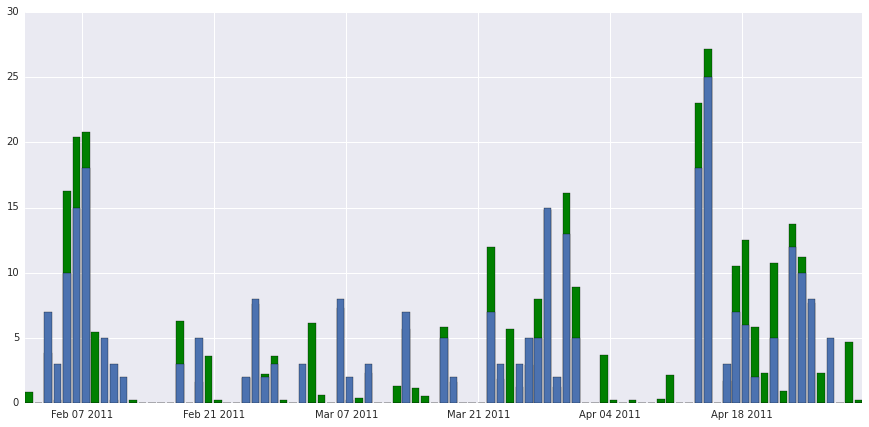

In [28]:
strt = '2011-2-1'
nd = '2011-4-30'

plt.figure(figsize=(15,7))
plt.bar(crn[strt:nd].index,crn[strt:nd].P, facecolor = 'g')
plt.bar(niwot[strt:nd].index, niwot[strt:nd].snowfall)


<Container object of 89 artists>

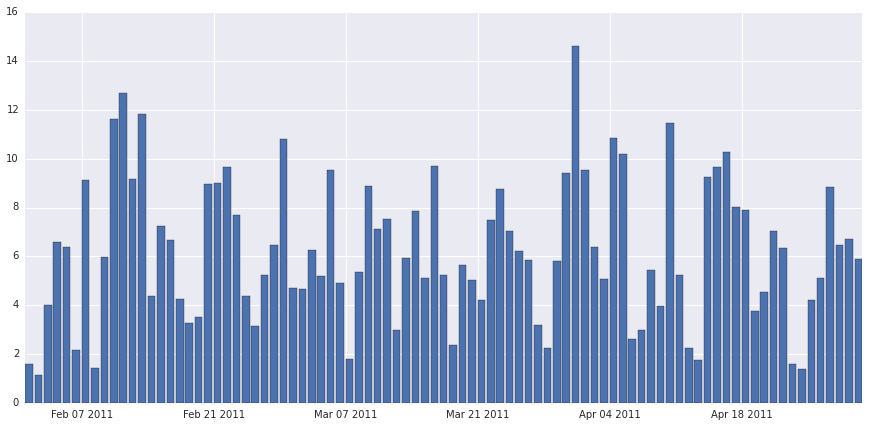

In [33]:
plt.figure(figsize=(15,7))
plt.bar(AFX[strt:nd].index,AFX[strt:nd].ws_21m)

In [63]:
oc = crn['P'] - niwot['snowfall'] 

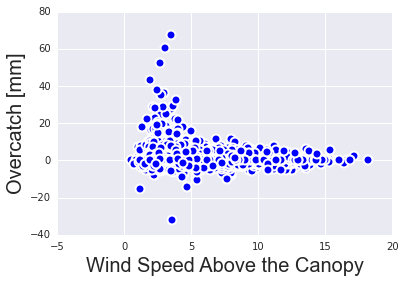

In [72]:
strt = AFX.index.min()
nd = AFX.index.max()

td = pd.datetools.timedelta(4)

plt.scatter(AFX[strt:nd].ws_21m,oc[strt+td:nd+td],s=80,edgecolor='w',lw=2)
plt.xlabel('Wind Speed Above the Canopy', fontsize = 20)
plt.ylabel('Overcatch [mm]', fontsize = 20)

In [61]:
td

datetime.timedelta(-4)

In [45]:
len(oc[strt:nd])

5540